# Find Lane Lines and Curvature with Advanced Computer Vision

In [315]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

---
## Camera Calibration and Image Undistortion

In [316]:
from tqdm import tqdm
import pickle

def calibration():
    camera_cal_dir = 'camera_cal'
    nx = 9
    ny = 6
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    MTX = np.empty(shape=(1,1))
    DIST = np.empty(shape=(1,1))
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
    for fname in tqdm(os.listdir(camera_cal_dir)):
        path = os.path.join(camera_cal_dir, fname)
        img = mpimg.imread(path)
        if len(img.shape) > 2:
            img_shape = img.shape[1::-1]
        else:
            img_shape = img.shape[::-1]
        ret, corners = cv2.findChessboardCorners(img, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                               imgpoints, 
                                                               img_shape, 
                                                               None, None)
            MTX = mtx
            DIST = dist
            print('calibration success.')
        else:
            print(f'calibration error {fname}.')

    try:
        output = open('mtx.p', 'wb')
        pickle.dump(MTX, output)
        output.close()

        output = open('dist.p', 'wb')
        pickle.dump(DIST, output)
        output.close()

        print('calibration mtx and dist saved successfully.')
    except Exception as e:
        print(f'fail to save calibration mtx and dist since {e}.')
    
def undistortion(img):
    if 'mtx.p' not in os.listdir() and 'dist.p' not in os.listdir():
        calibration()
    mtx = pickle.load( open( "mtx.p", "rb" ) )
    dist = pickle.load( open( "dist.p", "rb" ) )
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistort

---
## Thresholding

In [318]:
def absSobelThresh(gray, orient='x', sobel_kernel=3, thresh=(20, 100)):
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    return grad_binary

def magSobelThresh(gray, sobel_kernel=3, mag_thresh=(30, 100)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<mag_thresh[1])] = 1
    return mag_binary

def dirSobelThresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir>=thresh[0]) & (abs_grad_dir<=thresh[1])] = 1
    return dir_binary

def hlsThresh(img, s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

def combinedThresh(img):
    # find sobel binary
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = absSobelThresh(gray, orient='x', sobel_kernel=9, thresh=(20, 100))
    grady = absSobelThresh(gray, orient='y', sobel_kernel=9, thresh=(20, 100))
    mag_binary = magSobelThresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dirSobelThresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    sobel_binary = np.zeros_like(dir_binary)
    sobel_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # find hls s channel binary
    s_binary = hlsThresh(img, s_thresh=(170, 255))
    # combine sobel binary and s_binary
    combined = np.zeros_like(sobel_binary)
    combined[(sobel_binary == 1) | (s_binary == 1)] = 1
    
    return combined

---
## Perspective Transform

In [319]:
def warp(img, src, dst, h, w):
    M = cv2.getPerspectiveTransform(src, dst)
    perspective_trans = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return perspective_trans

def perspectiveTransform(img):
    h,w = img.shape[:2]
    # TODO: src and dst should be detected automatically
    left_bottom = [200, h]
    right_bottom = [1200, h]
    left_top = [550, 500]
    right_top = [750, 500]
    src = np.float32([left_bottom,right_bottom,left_top,right_top])
    dst = np.float32([[200,h], [1000,h], [300,0],[900,0]])
    warped = warp(img, src, dst, h, w)
    return warped

---
## Find the Lines with Histogram and Sliding Window
**this method only be used for the first frame (or the frame after continous error)**

In [321]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ######## Draw the windows on the visualization image ############
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ######## END Draw the windows on the visualization image ############
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, lefty, rightx, righty):

    #Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

---
## Draw

In [322]:
def drawLines(warped, 
              left_fitx, right_fitx, ploty, 
              leftx, lefty, rightx, righty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # find inverse perspective matrix (Minv)
    h,w = warped.shape[:2]
    left_bottom = [200, h]
    right_bottom = [1200, h]
    left_top = [550, 500]
    right_top = [750, 500]
    src = np.float32([left_bottom,right_bottom,left_top,right_top])
    dst = np.float32([[200,h], [1000,h], [300,0],[900,0]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

## Test Histogram and Sliding Window and Draw Lines

---
## Test on Images

### Test Undistortion

In [ ]:
img = mpimg.imread('camera_cal/calibration3.jpg')
img_undistort = undistortion(img)
plt.imshow(img_undistort)
plt.show()

### Test Thresholding

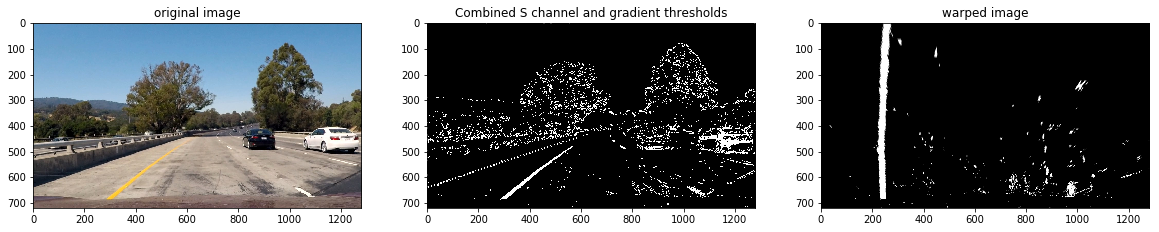

In [327]:
img = mpimg.imread('test_images/test3.jpg')
combined = combinedThresh(img)
warped = perspectiveTransform(combined)
# Plotting
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('original image')
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')

ax3.set_title('warped image')
ax3.imshow(warped, cmap='gray')

### Test Histogram and Sliding Window and Draw Lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


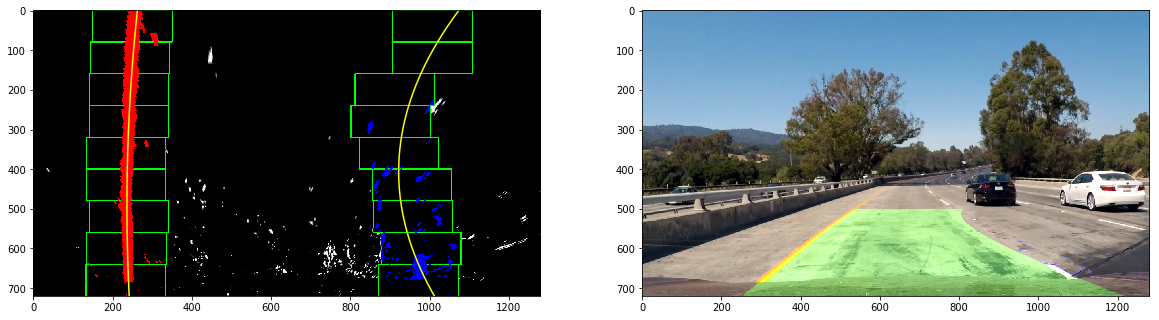

In [331]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
left_fitx, right_fitx, ploty = fit_poly(out_img.shape, lefty, rightx, righty)
result = drawLines(warped, 
          left_fitx, right_fitx, ploty, 
          leftx, lefty, rightx, righty)

## Visualization ##
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
ax1.set_title('line fit')
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.imshow(out_img)

ax1.set_title('final result')
ax2.imshow(result)

## Look-Ahead Filter
If you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

In [324]:
def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result